In [1]:
#Load file from database

from datasets import load_dataset
dataset_fin = load_dataset("zeroshot/twitter-financial-news-sentiment")
dataset_fin

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})

In [2]:
#Print the first element of the training set
dataset_fin["train"][0]

{'text': '$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT',
 'label': 0}

In [3]:
# Convert the dataset to a pandas dataframe
fin_df = dataset_fin["train"].to_pandas()
fin_df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [4]:
# inspect the features of the dataset
features = dataset_fin["train"].features
features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [5]:
# Check the distribution of the labels
fin_df['label'].value_counts(normalize=True).sort_index()

label
0    0.151106
1    0.201509
2    0.647386
Name: proportion, dtype: float64

Samples above have slightly lower counts for label "0", this may produce less accurate results for this group.

In [6]:
import re
import datasets
import nltk


# remove puctuations by eliminating characters that are not space and a character, using regex
def remove_punctuations(text): 
    punct_tag = re.compile(r'[^\w\s]')
    text = punct_tag.sub(r' ', text) 
    return text


# remove html using regex
def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    text = html_tag.sub(r' ', text)
    return text

# remove url using regex 
def remove_url(text):
    if text is None:
        return None
    url_clean = re.compile(r"https://\S+|www\.\S+")
    return url_clean.sub(r' ', text)

# remove emoji using re and unicode
def remove_emoji(text):
    if text is None:
        return None
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
    return emoji_clean.sub(r' ', str(text))
    url_clean = re.compile(r"https://\S+|www\.\S+")
    text = url_clean.sub(r'', text)
    return text

# tokenize the text using nltk
def stem(words):
    stemmer = nltk.stem.porter.PorterStemmer()
    return [stemmer.stem(word) for word in words]

# Preprocess the twitter dataset
def preprocess_twitter(ds):
    pipeline = (remove_punctuations, remove_html, remove_url, remove_emoji, nltk.tokenize.word_tokenize, stem)
    print(ds[0]["text"])

    for preprocess_funct in pipeline:
        ds = ds.map(lambda entry: {"text": preprocess_funct(entry["text"])})

    print(ds[0]["text"])
    return ds

# Load the dataset and preprocess it
def load_and_preprocess_twitter():
    dataset_name = "zeroshot/twitter-financial-news-sentiment"  
    ds = datasets.load_dataset(dataset_name)  
    for split in ["train", "validation"]:
        preprocess_twitter(ds[split]).save_to_disk(f"twitter_preprocessed_{split}")
    print([ds["train"][i]["text"] for i in range(10)])

    
load_and_preprocess_twitter()



$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT
['bynd', 'jpmorgan', 'reel', 'in', 'expect', 'on', 'beyond', 'meat', 'http', 't', 'co', 'bd0xbfgjkt']


Saving the dataset (0/1 shards):   0%|          | 0/9543 [00:00<?, ? examples/s]

$ALLY - Ally Financial pulls outlook https://t.co/G9Zdi1boy5
['alli', 'alli', 'financi', 'pull', 'outlook', 'http', 't', 'co', 'g9zdi1boy5']


Saving the dataset (0/1 shards):   0%|          | 0/2388 [00:00<?, ? examples/s]

['$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT', '$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3', '$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb', '$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N', '$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB', '$FTI - TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank https://t.co/XKcPDilIuU', '$GM - GM loses a bull https://t.co/tdUfG5HbXy', '$GM: Deutsche Bank cuts to Hold https://t.co/7Fv1ZiFZBS', '$GTT: Cowen cuts to Market Perform', '$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone estimate after Foxconn delay https://t.co/rlnEwzlzzS']


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import datasets
import numpy as np


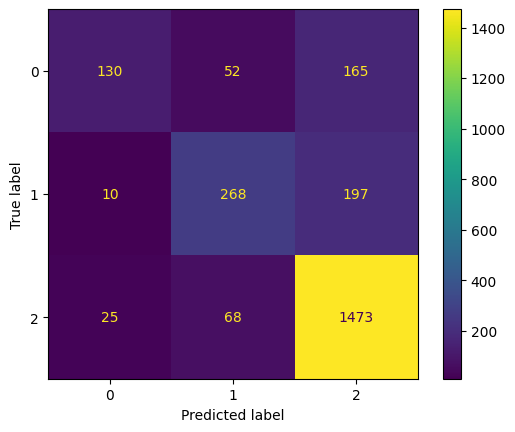

In [9]:
ds = datasets.load_from_disk("twitter_preprocessed_train")
count_vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, max_df=1.0, min_df=0.0)
document_word_counts = count_vectorizer.fit_transform(ds["text"])
NB_classifier = MultinomialNB().fit(document_word_counts, ds["label"])


ds_test = datasets.load_from_disk("twitter_preprocessed_validation")
predictions = NB_classifier.predict(count_vectorizer.transform(ds_test["text"]))
conf_matrix = confusion_matrix(ds_test["label"], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=NB_classifier.classes_)
disp.plot()
plt.show()

# plt.imshow(conf_matrix, cmap='binary', interpolation='None')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.xticks(range(conf_matrix.shape[0]))
# plt.yticks(range(conf_matrix.shape[0]))

# for (j,i), label in np.ndenumerate(conf_matrix):
#     plt.text(i,j, label, ha='center', va='center')
# plt.show()
